In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
import pickle
from tqdm import tqdm
import math 
import time
import csv
import glob
import os

import logging
# from model import LSTM
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)



In [2]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 添加Layer Normalization
        self.ln = nn.LayerNorm(hidden_size)
        
        # 全连接层 - 包含一个隐藏层，增加非线性映射能力
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            # nn.Linear(hidden_size // 2, output_size)
            nn.Linear(hidden_size // 2, output_size)
            # 不再使用ReLU激活函数在最后一层，适用于回归任务
        )
        
        # 初始化LSTM权重
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM层前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 使用Layer Normalization
        out = self.ln(out[:, -1, :])
        
        # 全连接层前向传播
        out = self.fc(out)
        # out = out.view(out.size(0), 5, 10)  # Reshape output to (batch_size, 5, 10)    
        return out


In [50]:
### 14根传感器预测27个角度
trial_id = 'test_0806_1'


train_folder = 'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\data\model_training\\train'  # 文件夹路径
train_csv_files = glob.glob(os.path.join(train_folder, '*.csv'))
data_train_list = [pd.read_csv(f) for f in train_csv_files]
print(train_csv_files)
data_train = pd.concat(data_train_list, ignore_index=True)
print(f"训练集文件数: {len(train_csv_files)}, 合并后shape: {data_train.shape}")

test_folder ='F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\data\model_training\\test' # 文件夹路径
test_csv_files = glob.glob(os.path.join(test_folder, '*.csv'))
data_test_list = [pd.read_csv(f) for f in test_csv_files]
data_test = pd.concat(data_test_list, ignore_index=True)
print(f"测试集文件数: {len(test_csv_files)}, 合并后shape: {data_test.shape}")

# 自动获取传感器和角度列名
sensor_cols = data_train.columns[1:15]   # 第2~15列
angle_cols = data_train.columns[15:42]   # 第16~42列（27个角度）

sensor_data_train_raw = data_train[sensor_cols].values
angle_data_train_raw = data_train[angle_cols].values
sensor_data_test_raw = data_test[sensor_cols].values
angle_data_test_raw = data_test[angle_cols].values

# Normalize the data
# from sklearn import MinMaxScaler
sensor_scaler = MinMaxScaler()
angle_scaler = MinMaxScaler()
scaler_dir = 'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\predict\scaler'

sensor_data_train = sensor_scaler.fit_transform(sensor_data_train_raw)
angle_data_train = angle_scaler.fit_transform(angle_data_train_raw)
sensor_data_test = sensor_scaler.fit_transform(sensor_data_test_raw)
angle_data_test = angle_scaler.fit_transform(angle_data_test_raw)


# 检查MinMaxScaler的数据范围（而不是标准差）
sensor_data_range = sensor_scaler.data_max_ - sensor_scaler.data_min_
angle_data_range = angle_scaler.data_max_ - angle_scaler.data_min_

if np.any(sensor_data_range == 0):
    zero_range_cols = np.where(sensor_data_range == 0)[0]
    print(f"⚠️ 警告: 传感器数据中第 {zero_range_cols} 列的取值范围为 0（所有值相同）")
    
if np.any(angle_data_range == 0):
    zero_range_cols = np.where(angle_data_range == 0)[0]
    print(f"⚠️ 警告: 角度数据中第 {zero_range_cols} 列的取值范围为 0（所有值相同）")


with open(f'{scaler_dir}/sensor_scaler_{trial_id}.pkl', 'wb') as f:
    pickle.dump(sensor_scaler, f)
print(f"✓ 传感器标准化器已保存到: {scaler_dir}/sensor_scaler_{trial_id}.pkl")

with open(f'{scaler_dir}/angle_scaler_{trial_id}.pkl', 'wb') as f:
    pickle.dump(angle_scaler, f)
print(f"✓ 角度标准化器已保存到: {scaler_dir}/angle_scaler_{trial_id}.pkl")
    

['F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_AB60J.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_AB90J.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_AB_fps30.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_AB_fps60.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_AB_fps90.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_C_AB_fps30_moni15.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_C_AB_fps30_qugan_5kg_L.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_C_AB_fps30_qugan_5kg_R.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_C_AB_fps30_songjian_5kg_L.csv', 'F:\\coding\\ShoulDeX\\ShoulDex_v1.0\\ShoulDeX\\data\\model_training\\train\\P1_C_AB_fps30_songj

In [49]:
### 【单侧 —— 右侧】14根传感器预测15个角度
trial_id = 'right_side_14sensor_15angle'


train_folder = 'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\data\model_training\\train'  # 文件夹路径
train_csv_files = glob.glob(os.path.join(train_folder, '*.csv'))
data_train_list = [pd.read_csv(f) for f in train_csv_files]
# print(train_csv_files)
data_train = pd.concat(data_train_list, ignore_index=True)
print(f"训练集文件数: {len(train_csv_files)}, 合并后shape: {data_train.shape}")

test_folder ='F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\data\model_training\\test' # 文件夹路径
test_csv_files = glob.glob(os.path.join(test_folder, '*.csv'))
data_test_list = [pd.read_csv(f) for f in test_csv_files]
data_test = pd.concat(data_test_list, ignore_index=True)
print(f"测试集文件数: {len(test_csv_files)}, 合并后shape: {data_test.shape}")

# 自动获取传感器和角度列名
sensor_cols = data_train.columns[1:15]   # 第2~15列

# 只选择右侧相关的15个角度
right_side_angle_indices = [
    # 右肱骨与胸廓坐标系角度 (原索引 3,4,5 -> 列索引 15+3,15+4,15+5)
    18, 19, 20,  # A_humerus_r_thorax_X, A_humerus_r_thorax_Y, A_humerus_r_thorax_Z
    # 右肩胛骨与胸廓坐标系角度 (原索引 9,10,11 -> 列索引 15+9,15+10,15+11) 
    24, 25, 26,  # A_scapula_r_thorax_X, A_scapula_r_thorax_Y, A_scapula_r_thorax_Z
    # 右锁骨与胸廓坐标系角度 (原索引 15,16,17 -> 列索引 15+15,15+16,15+17)
    30, 31, 32,  # A_clavicle_r_thorax_X, A_clavicle_r_thorax_Y, A_clavicle_r_thorax_Z
    # 右肱骨与右肩胛骨坐标系角度 (原索引 21,22,23 -> 列索引 15+21,15+22,15+23)
    36, 37, 38,  # A_humerus_r_scapula_X, A_humerus_r_scapula_Y, A_humerus_r_scapula_Z
    # 胸廓与髋关节坐标系角度 (原索引 24,25,26 -> 列索引 15+24,15+25,15+26)
    39, 40, 41   # A_thorax_hip_X, A_thorax_hip_Y, A_thorax_hip_Z
]
# 根据索引选择右侧角度列
angle_cols = data_train.columns[right_side_angle_indices]

sensor_data_train_raw = data_train[sensor_cols].values
angle_data_train_raw = data_train[angle_cols].values
sensor_data_test_raw = data_test[sensor_cols].values
angle_data_test_raw = data_test[angle_cols].values

print("传感器列名:", list(sensor_cols))
print("角度列名:", list(angle_cols))


# Normalize the data
# from sklearn import MinMaxScaler
sensor_scaler = MinMaxScaler()
angle_scaler = MinMaxScaler()
scaler_dir = 'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\predict\scaler'

sensor_data_train = sensor_scaler.fit_transform(sensor_data_train_raw)
angle_data_train = angle_scaler.fit_transform(angle_data_train_raw)
sensor_data_test = sensor_scaler.fit_transform(sensor_data_test_raw)
angle_data_test = angle_scaler.fit_transform(angle_data_test_raw)


# 检查MinMaxScaler的数据范围（而不是标准差）
sensor_data_range = sensor_scaler.data_max_ - sensor_scaler.data_min_
angle_data_range = angle_scaler.data_max_ - angle_scaler.data_min_

if np.any(sensor_data_range == 0):
    zero_range_cols = np.where(sensor_data_range == 0)[0]
    print(f"⚠️ 警告: 传感器数据中第 {zero_range_cols} 列的取值范围为 0（所有值相同）")
    
if np.any(angle_data_range == 0):
    zero_range_cols = np.where(angle_data_range == 0)[0]
    print(f"⚠️ 警告: 角度数据中第 {zero_range_cols} 列的取值范围为 0（所有值相同）")


with open(f'{scaler_dir}/sensor_scaler_{trial_id}.pkl', 'wb') as f:
    pickle.dump(sensor_scaler, f)
print(f"✓ 传感器标准化器已保存到: {scaler_dir}/sensor_scaler_{trial_id}.pkl")

with open(f'{scaler_dir}/angle_scaler_{trial_id}.pkl', 'wb') as f:
    pickle.dump(angle_scaler, f)
print(f"✓ 角度标准化器已保存到: {scaler_dir}/angle_scaler_{trial_id}.pkl")
    

# # 保存 scaler
# with open(f'./predict/scaler/sensor_scaler_{trial_id}.pkl', 'wb') as f:
#     pickle.dump(sensor_data_train, f)
# with open(f'./predict/scaler/angle_scaler{trial_id}.pkl', 'wb') as f:
#     pickle.dump(angle_data_train, f)

训练集文件数: 61, 合并后shape: (79228, 42)
测试集文件数: 21, 合并后shape: (22264, 42)
传感器列名: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14']
角度列名: ['A_humerus_r_thorax_X', 'A_humerus_r_thorax_Y', 'A_humerus_r_thorax_Z', 'A_scapula_r_thorax_X', 'A_scapula_r_thorax_Y', 'A_scapula_r_thorax_Z', 'A_clavicle_r_thorax_X', 'A_clavicle_r_thorax_Y', 'A_clavicle_r_thorax_Z', 'A_humerus_r_scapula_X', 'A_humerus_r_scapula_Y', 'A_humerus_r_scapula_Z', 'A_thorax_hip_X', 'A_thorax_hip_Y', 'A_thorax_hip_Z']
✓ 传感器标准化器已保存到: F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\predict\scaler/sensor_scaler_right_side_14sensor_15angle.pkl
✓ 角度标准化器已保存到: F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\predict\scaler/angle_scaler_right_side_14sensor_15angle.pkl


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # 输出使用的设备
# Load data

Using device: cuda


In [31]:
time_steps = 3
window_length = 60
# Define function to create the dataset with a given time step
# def create_dataset(X, y, window_length):
#     Xs = []
#     ys = []
#     print((len(X) - window_length)/time_steps)
#     for i in range(int((len(X) - window_length)/time_steps)):
#         Xs.append(X[i*time_steps:(i*time_steps + window_length)])
#         ys.append(y[i*time_steps + window_length])
#     return np.array(Xs), np.array(ys)

def create_dataset(X, y, window_length):
    Xs = []
    ys = []
    print((len(X) - window_length)/time_steps)
    for i in range(int((len(X) - window_length)/time_steps)):
        Xs.append(X[i*time_steps:(i*time_steps + window_length)])
        ys.append(y[i*time_steps + window_length])
    return np.array(Xs), np.array(ys)

X_trainset, y_trainset = create_dataset(sensor_data_train, angle_data_train, window_length)
X_testset, y_testset = create_dataset(sensor_data_test, angle_data_test, window_length)

print(len(X_testset))
print(len(angle_data_test))
# Split data into train, validation and test sets
# X_train, X_val, y_train, y_val = train_test_split(X_trainset, y_trainset, test_size=0.20, random_state=40)
# Split data into train and validation sets without shuffling
X_train, X_val, y_train, y_val = train_test_split(X_trainset, y_trainset, test_size=0.20, random_state=42, shuffle=True)
# X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)


# Convert data to tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_val = torch.from_numpy(X_val).float().to(device)
y_val = torch.from_numpy(y_val).float().to(device)
X_test = torch.from_numpy(X_testset).float().to(device)
y_test = torch.from_numpy(y_testset).float().to(device)

26389.333333333332
7401.333333333333
7401
22264


In [32]:

print(len(X_trainset))
print(len(X_val))
print(len(X_test))
print(len(X_testset))

26389
5278
7401
7401


In [33]:
batch_size = 256
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# Set the model parameters
input_size = sensor_number
# conv_input = 10
hidden_size = 256
num_layers = 3
output_size = angle_number
dropout = 0.1
# Set training parameters
num_epochs = 300

In [35]:
# from model import LSTM
# model = LSTM_op(input_size, hidden_size, num_layers, output_size, dropout).to(device)
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)
print(model)


LSTM(
  (lstm): LSTM(14, 256, num_layers=3, batch_first=True)
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=15, bias=True)
  )
)


In [36]:
def l2_regularizer(weight, lambda_l2):
    return lambda_l2 * torch.norm(weight, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()
# criterion = nn.msleloss()


#Define the learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses = []
val_losses = []  
A_loss = []
labmda_A = 1

In [37]:
# 设置早停参数

early_stopping_patience = 10  # 连续多少个epoch验证损失没有改善则停止
early_stopping_threshold = 1e-05  # 损失减少小于这个阈值时认为没有改善
# P8  early_stopping_threshold: 3e-04

# 添加一个队列来存放最近的验证损失值
recent_val_losses = deque(maxlen=early_stopping_patience)
# 获取当前时间戳
current_time = time.strftime("%Y%m%d-%H%M%S")
# log_file_path = f'01dataprocess_code/data/result/{participant_id}/training_log_{participant_id}_{current_time}.txt'
log_file_path = f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\log\\training_log\log_{trial_id}.txt'
model_params = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'num_epochs': num_epochs,
    'learning_rate': 0.01,
    'lambda_l2': 0.0003,
    'early_stopping_patience': early_stopping_patience,
    'early_stopping_threshold': early_stopping_threshold
}

In [38]:
# 打开文件以便写入
with open(log_file_path, 'w') as log_file:
    # 写入模型参数到日志文件
    log_file.write("Model Parameters:\n")
    for param_name, param_value in model_params.items():
        log_file.write(f"{param_name}: {param_value}\n")
    log_file.write("\n")  # 添加一个空行以区分模型参数和训练日志

    model.train()
    best_val_loss = float('inf')  # 初始化最好的验证损失为正无穷大
    stop_training = False

    print(f"Start training, totally {num_epochs} epoch...")
    print("-" * 80)
    start_time = time.time()
    
    for epoch in range(num_epochs):
        if stop_training:
            print(f"\n Early stop at {epoch} epoch")
            log_file.write(f"Early stopping triggered at epoch {epoch}\n")
            break

        model.train()
        epoch_start_time = time.time()
        
        # 简单显示当前epoch进度
        batch_count = 0
        total_batches = len(train_loader)
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 原始传感器振幅的loss
            optimizer.zero_grad()
            output = model(X_batch)
            train_loss = criterion(output, y_batch)

            # 正则化
            l2_reg = 0
            for param in model.parameters():
                l2_reg += l2_regularizer(param, lambda_l2=0.0003)
            loss = train_loss + l2_reg
            loss.backward()
            optimizer.step()
            
            batch_count += 1

        # 更新学习率
        scheduler.step()
        model.eval()
        val_loss_total = 0
        with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    output = model(X_batch)
                    val_loss = criterion(output, y_batch)
                    val_loss_total += val_loss.item()

        val_loss_avg = val_loss_total / len(val_loader)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss_avg)
        
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # 每10个epoch或者最后一个epoch显示详细信息
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            progress = (epoch + 1) / num_epochs * 100
            eta = (total_time / (epoch + 1)) * (num_epochs - epoch - 1)
            
            print(f"Epoch {epoch+1:3d}/{num_epochs} ({progress:5.1f}%) | "
                  f"Train: {train_loss.item():.8f} | Val: {val_loss_avg:.8f} | "
                  f"Time: {epoch_time:.6f}s | ETA: {eta/60:.1f}min")
            
        # 每个epoch简单显示一个点表示进度
        elif epoch % 1 == 0:
            print("-", end="", flush=True)
            
        log_file.write(f"epoch:{epoch}, train_loss:{train_loss.item()}, val_loss:{val_loss_avg}\n")
        
        # 如果当前的验证损失比之前最好的验证损失好，更新最好的验证损失
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
        
        # 将当前验证损失添加到队列中
        recent_val_losses.append(val_loss_avg)
        
        # 检查队列中的损失是否没有显著减少
        if len(recent_val_losses) == early_stopping_patience:
            if all((recent_val_losses[i-1] - recent_val_losses[i]) < early_stopping_threshold for i in range(1, len(recent_val_losses))):
                stop_training = True

    # Save the model
    total_training_time = time.time() - start_time
    
    # 定义模型保存路径
    model_save_path = f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\model\{trial_id}_lstm.pth'
    
    # 保存模型
    torch.save(model.state_dict(), model_save_path)
    
    print(f"\n" + "=" * 80)
    print(f"训练完成！总耗时: {total_training_time/60:.1f} 分钟")
    print(f"模型已保存: {model_save_path}")
    print(f"最终结果 - Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss_avg:.4f}")
    print(f"最佳验证损失: {best_val_loss:.4f}")
    print("=" * 80)
    
    log_file.write(f"模型已保存为 {model_save_path}\n")
    log_file.write(f"总训练时间: {total_training_time/60:.1f} 分钟\n")
    
print(f"Training log saved to {log_file_path}")

Start training, totally 300 epoch...
--------------------------------------------------------------------------------
Epoch   1/300 (  0.3%) | Train: 0.01195646 | Val: 0.01007126 | Time: 2.063842s | ETA: 10.3min
---------Epoch  11/300 (  3.7%) | Train: 0.00391066 | Val: 0.00323048 | Time: 1.787889s | ETA: 9.0min
---------Epoch  21/300 (  7.0%) | Train: 0.00378947 | Val: 0.00287042 | Time: 1.869749s | ETA: 8.6min
---------Epoch  31/300 ( 10.3%) | Train: 0.00344907 | Val: 0.00311740 | Time: 1.837870s | ETA: 8.3min
---------Epoch  41/300 ( 13.7%) | Train: 0.00353666 | Val: 0.00302577 | Time: 1.804520s | ETA: 8.0min
---------Epoch  51/300 ( 17.0%) | Train: 0.00345084 | Val: 0.00313889 | Time: 1.777745s | ETA: 7.6min
---------Epoch  61/300 ( 20.3%) | Train: 0.00308342 | Val: 0.00290112 | Time: 1.775497s | ETA: 7.3min
---------Epoch  71/300 ( 23.7%) | Train: 0.00316057 | Val: 0.00292676 | Time: 1.724867s | ETA: 7.0min
---------Epoch  81/300 ( 27.0%) | Train: 0.00310738 | Val: 0.00291516 | Ti

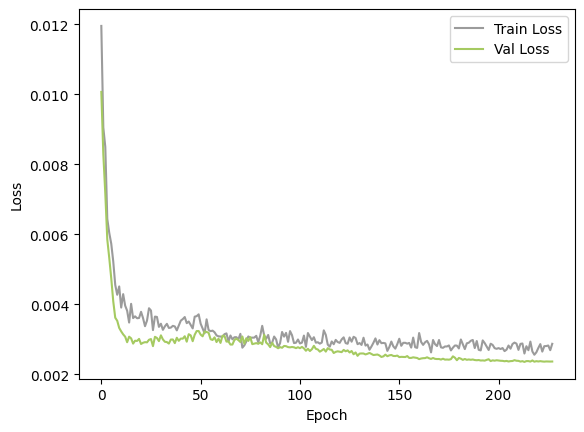

In [39]:
import os
# 创建保存图像的路径
result_dir = f'./result/figure/{trial_id}'
os.makedirs(result_dir, exist_ok=True)  # 如果文件夹不存在则创建
# 保存图像的文件路径
image_path_loss = f'{result_dir}\\{trial_id}_{current_time}_loss_plot.png'

plt.plot(train_losses, label='Train Loss', color = '#9B9B9B')
plt.plot(val_losses, label='Val Loss', color = '#A5CA61')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(image_path_loss)  # 保存图像到文件
plt.show()


In [40]:
model.load_state_dict(torch.load(f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDeX\model\\{trial_id}_lstm.pth'))
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    test_outputs = model(X_test)

In [41]:
print("X_batch shape:", X_batch.shape)  # 输入的形状
print("output shape:", output.shape)    # 输出的形状
print("y_batch shape:", y_batch.shape)  # 目标值的形状

X_batch shape: torch.Size([158, 60, 14])
output shape: torch.Size([158, 15])
y_batch shape: torch.Size([158, 15])


In [42]:
# Calculate the RMSE for each dimension separately
def calculate_rmse(y_true, y_pred):
    rmse_per_dimension = []
    # mean_true = np.mean(y_true)
    for i in range(y_true.shape[1]):
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        # normalized_error_mean = rmse / mean_true

        rmse_per_dimension.append(rmse)

    return rmse_per_dimension


# 计算归一化数据的 RMSE
train_rmse_normalized = calculate_rmse(y_train.cpu(), train_outputs.cpu())
test_rmse_normalized = calculate_rmse(y_test.cpu(), test_outputs.cpu())

# Calculate the RMS
y_train_inv = scaler.inverse_transform(y_train.cpu())
train_pred_inv = scaler.inverse_transform(train_outputs.cpu())
train_rmse_per_dim = calculate_rmse(y_train_inv, train_pred_inv)

y_test_inv = scaler.inverse_transform(y_test.cpu())
test_pred_inv = scaler.inverse_transform(test_outputs.cpu())
test_rmse_per_dim = calculate_rmse(y_test_inv, test_pred_inv)

print(f"NORMALIZED Train RMSE per dimension: {train_rmse_normalized}")
print(f"NORMALIZED Test RMSE per dimension: {test_rmse_normalized}")

print(f"Train RMSE per dimension: {train_rmse_per_dim}")
print(f"Test RMSE per dimension: {test_rmse_per_dim}")

NORMALIZED Train RMSE per dimension: [0.03567072, 0.03259324, 0.036676113, 0.05373742, 0.055671338, 0.03449906, 0.059300415, 0.058738306, 0.03614271, 0.036619388, 0.037219036, 0.031272855, 0.056224816, 0.06297817, 0.060057804]
NORMALIZED Test RMSE per dimension: [0.06516103, 0.11196097, 0.10778717, 0.1775875, 0.13002338, 0.14646377, 0.27365783, 0.1780999, 0.11151829, 0.079034135, 0.09156497, 0.12697704, 0.22761951, 0.20245841, 0.17753784]
Train RMSE per dimension: [2.7672793506367066, 4.049208680087815, 3.877379912500533, 1.638871604168118, 1.655994241990037, 1.0648249330182165, 5.003683963833126, 1.2085384597063507, 1.1749542594413087, 1.8520814442082876, 3.57411614723153, 2.4980901166121767, 1.1755814927852757, 1.3742959982681249, 1.2706546699622892]
Test RMSE per dimension: [5.055091783132817, 13.90942948597517, 11.395203936191416, 5.416023326704227, 3.86766267793002, 4.52065271305431, 23.09085562358545, 3.6643989171331053, 3.6253201622956452, 3.997272290376872, 8.792914735618908, 1

In [43]:
print("train_pred_inv shape:", train_pred_inv.shape)
print("y_train_inv shape:", y_train_inv.shape)
print("test_pred_inv shape:", test_pred_inv.shape)
print("y_test_inv shape:", y_test_inv.shape)


train_pred_inv shape: (21111, 15)
y_train_inv shape: (21111, 15)
test_pred_inv shape: (7401, 15)
y_test_inv shape: (7401, 15)


In [44]:
# 计算训练集和测试集上RMSE的平均值
train_rmse_mean = np.mean(train_rmse_per_dim)
test_rmse_mean = np.mean(test_rmse_per_dim)
print(f"Average Train RMSE: {train_rmse_mean}")
print(f"Average Test RMSE: {test_rmse_mean}")

Average Train RMSE: 2.2790370182966595
Average Test RMSE: 7.360747967868933


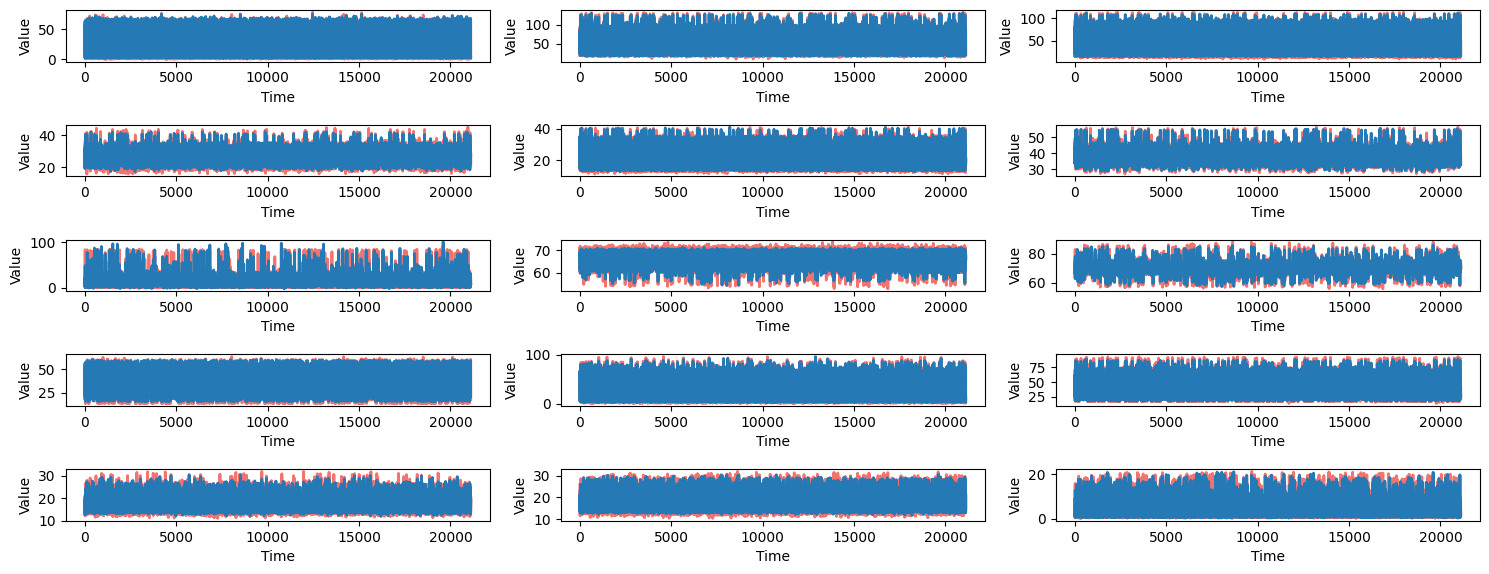

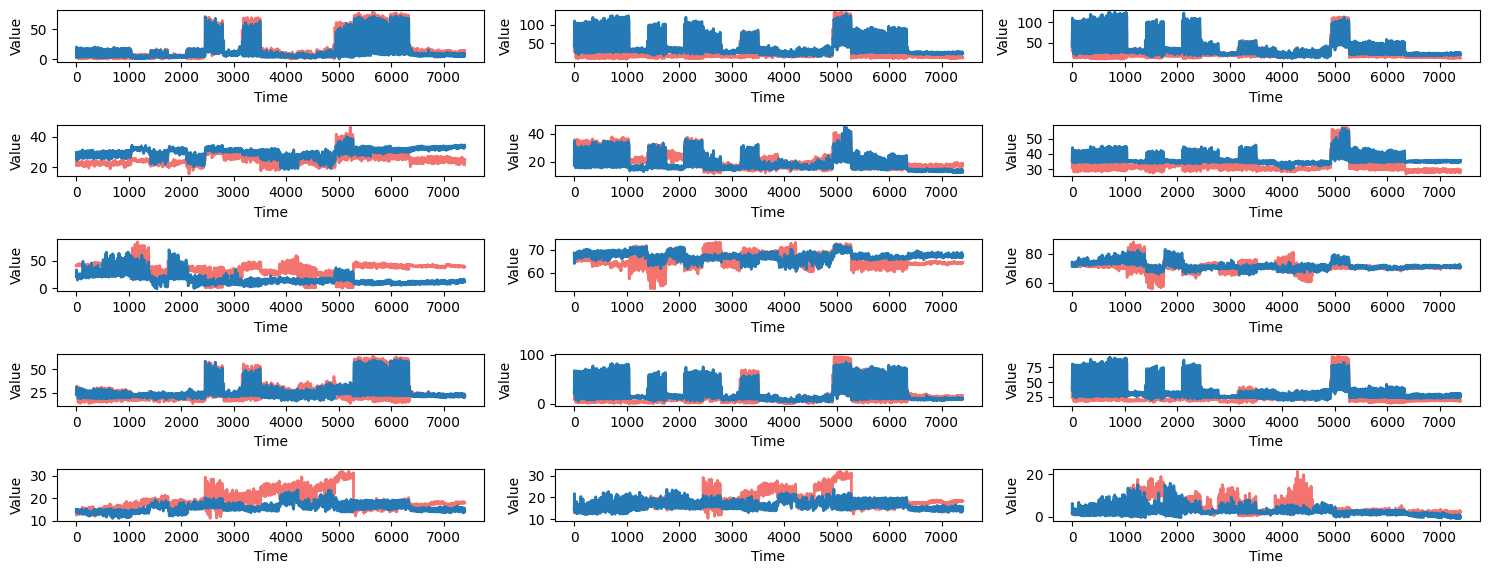

In [45]:

# 保存图像的文件路径
image_path_angleresult_train = f'{result_dir}\\{trial_id}_{current_time}_res_train.png'
# Plotting for training set
plt.figure(figsize=(15, 10))
for i in range(y_train_inv.shape[1]):
    plt.subplot(9, 3, i+1)
    plt.plot(y_train_inv[:, i], label='Actual Train', color ="#F3736F", linewidth = 2.0 )
    plt.plot(train_pred_inv[:, i], label='Predicted Train', color ="#257AB6", linewidth = 2.0 )
    # plt.legend()
    # plt.title(f'Actual vs Predicted - Train (Dimension {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.savefig(image_path_angleresult_train)  # 保存图像到文件
plt.show()

# Plotting for test set
image_path_angleresult_test = f'{result_dir}\\{trial_id}_{current_time}_res_test.png'
plt.figure(figsize=(15, 10))
for i in range(y_test_inv.shape[1]):
    plt.subplot(9, 3, i+1)
    plt.plot(y_test_inv[:, i], label='Actual Test', color ="#F3736F" , linewidth = 2.0)
    plt.plot(test_pred_inv[:, i], label='Predicted Test' , color ="#257AB6" , linewidth = 2.0)
    # plt.legend()
    # plt.title(f'Actual vs Predicted - Test (Dimension {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.savefig(image_path_angleresult_test)  # 保存图像到文件
plt.show()



In [97]:
# 计算训练集和测试集上RMSE的平均值
train_rmse_mean = np.mean(train_rmse_per_dim)
print(f"Average Train RMSE: {train_rmse_mean}")

header = ['angle1_groundtruth', 'angle1_pred', 'angle2_groundtruth', 'angle2_pred', 'angle3_groundtruth', 'angle3_pred', 'angle4_groundtruth', 'angle4_pred', 'angle5_groundtruth', 'angle5_pred', 'angle6_groundtruth', 'angle6_pred', 'angle7_groundtruth', 'angle7_pred', 'angle8_groundtruth', 'angle8_pred', 'angle9_groundtruth', 'angle9_pred' ]
# header = ['angle1_groundtruth', 'angle1_pred', 'angle2_groundtruth', 'angle2_pred', 'angle3_groundtruth', 'angle3_pred']

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_train_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for row_idx in range(y_train_inv.shape[0]):
        merge_row = []
        for col_idx in range(y_train_inv.shape[1]):
            merge_row.append(y_train_inv[row_idx][col_idx])
            merge_row.append(train_pred_inv[row_idx][col_idx])
        writer.writerow(merge_row)

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_test_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for row_idx in range(y_test_inv.shape[0]):
        merge_row = []
        for col_idx in range(y_test_inv.shape[1]):
            merge_row.append(y_test_inv[row_idx][col_idx])
            merge_row.append(test_pred_inv[row_idx][col_idx])
        writer.writerow(merge_row)

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_RMSE.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    header = ['NORMALIZED Train RMSE per dimension', 'NORMALIZED Test RMSE per dimension', 'Train RMSE per dimension', 'Test RMSE per dimension', 'Average Train RMSE', 'Average Test RMSE']
    writer.writerow(header)
    for i in range(angle_number):
        row = [train_rmse_normalized[i], test_rmse_normalized[i], train_rmse_per_dim[i], test_rmse_per_dim[i]]
        if i == 0:
            row.extend([train_rmse_mean, test_rmse_mean])
        else:
            row.extend(['',''])
        writer.writerow(row)



Average Train RMSE: 2.582934587347135
